#### .

In [ ]:
!python -m pip install --upgrade pip
!pip3 uninstall numpy -y
!pip3 uninstall d2l -y
!pip3 uninstall tensorflow -y
!pip3 uninstall matplotlib -y
!pip3 uninstall pandas -y
!pip3 install d2l
!pip3 install tensorflow
!pip3 install pandas
!pip3 install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: d2l 0.17.6
Uninstalling d2l-0.17.6:
  Successfully uninstalled d2l-0.17.6
Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0
Found existing installation: matplotlib 3.5.1
Uninstalling matplotlib-3.5.1:
  Successfully uninstalled matplotlib-3.5.1
Found existing installation: pandas 1.2.4
Uninstalling pandas-1.2.4:
  Successfully uninstalled pandas-1.2.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached d2l-0.17.6-py3-none-any.whl (112 kB)
  Using cached numpy-1.21.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (15.9 MB)
  Using cached matplotlib-3.5.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.9 MB)
  Using cached pandas-1.2.4-cp310-cp310-linux_x86_64.whl
ERROR: pip's dependency resolver does 

In [ ]:
import time
import numpy as np
import inspect
import collections
from IPython import display
import tensorflow as tf
from d2l import torch as d2l

def add_to_class(Class):
    """Register functions as methods in created class."""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

class HyperParameters:
    """The base class of hyperparameters."""
    def save_hyperparameters(self, ignore=[]):
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)
        self.hparams = {k:v for k, v in local_vars.items()
                        if k not in set(ignore+['self']) and not k.startswith('_')}
        for k, v in self.hparams.items():
            setattr(self, k, v)

In [ ]:
class ProgressBoard(HyperParameters):
    """The board that plots data points in animation."""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        Point = collections.namedtuple('Point', ['x', 'y'])
        if not hasattr(self, 'raw_points'):
            self.raw_points = collections.OrderedDict()
            self.data = collections.OrderedDict()
        if label not in self.raw_points:
            self.raw_points[label] = []
            self.data[label] = []
        points = self.raw_points[label]
        line = self.data[label]
        points.append(Point(x, y))
        if len(points) != every_n:
            return
        mean = lambda x: sum(x) / len(x)
        line.append(Point(mean([p.x for p in points]),
                          mean([p.y for p in points])))
        points.clear()
        if not self.display:
            return
        d2l.use_svg_display()
        if self.fig is None:
            self.fig = d2l.plt.figure(figsize=self.figsize)
        plt_lines, labels = [], []
        for (k, v), ls, color in zip(self.data.items(), self.ls, self.colors):
            plt_lines.append(d2l.plt.plot([p.x for p in v], [p.y for p in v],
                                          linestyle=ls, color=color)[0])
            labels.append(k)
        axes = self.axes if self.axes else d2l.plt.gca()
        if self.xlim: axes.set_xlim(self.xlim)
        if self.ylim: axes.set_ylim(self.ylim)
        if not self.xlabel: self.xlabel = self.x
        axes.set_xlabel(self.xlabel)
        axes.set_ylabel(self.ylabel)
        axes.set_xscale(self.xscale)
        axes.set_yscale(self.yscale)
        axes.legend(plt_lines, labels)
        display.display(self.fig)
        display.clear_output(wait=True)

In [ ]:
class Module(tf.keras.Model, HyperParameters):
    """The base class of models."""
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()
        self.training = None

    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def call(self, X, *args, **kwargs):
        if kwargs and "training" in kwargs:
            self.training = kwargs['training']
        return self.forward(X, *args)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.numpy(), (
            'train_' if train else 'val_') + key, every_n=int(n))
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        raise NotImplementedError

class DataModule(HyperParameters):
    """The base class of data."""
    def __init__(self, root='../data'):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

class Trainer(HyperParameters):
    """The base class for training models with data."""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.save_hyperparameters()
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        self.model.training = True
        for batch in self.train_dataloader:
            with tf.GradientTape() as tape:
                loss = self.model.training_step(self.prepare_batch(batch))
            grads = tape.gradient(loss, self.model.trainable_variables)
            if self.gradient_clip_val > 0:
                grads = self.clip_gradients(self.gradient_clip_val, grads)
            self.optim.apply_gradients(zip(grads, self.model.trainable_variables))
            self.train_batch_idx += 1
        if self.val_dataloader is None:
            return
        self.model.training = False
        for batch in self.val_dataloader:
            self.model.validation_step(self.prepare_batch(batch))
            self.val_batch_idx += 1
    def prepare_batch(self, batch):
        return batch

## 4.1. **Softmax Regression**

#### 4.1.1. Classification

##### 4.1.1.1. Linear Model

Classification을 할 때 Regression과 유사한 선형식으로 확률을 추정한다.

\begin{split}\begin{aligned}
o_1 &= x_1 w_{11} + x_2 w_{12} + x_3 w_{13} + x_4 w_{14} + b_1,\\
o_2 &= x_1 w_{21} + x_2 w_{22} + x_3 w_{23} + x_4 w_{24} + b_2,\\
o_3 &= x_1 w_{31} + x_2 w_{32} + x_3 w_{33} + x_4 w_{34} + b_3.
\end{aligned}\end{split}

Weight 행렬을 $W$로 놓고, input, bias 벡터를 $x, b$로 표현하면

$𝛐 = Wx + b$ 로 나타낼 수 있다.

##### 4.1.1.2. The Softmax

Softmax는 위와 같은 선형식으로 예측한 값을 정규화해준다.

$\hat{\mathbf{y}} = \mathrm{softmax}(\mathbf{o}) \quad \text{where}\quad \hat{y}_i = \frac{\exp(o_i)}{\sum_j \exp(o_j)}$.

$\hat{\mathbf{y}}$의 모든 원소의 합은 1이 된다. 즉, 확률로 나타낼 수 있다.

##### 4.1.1.3. Vectorization

$\begin{split}\begin{aligned} \mathbf{O} &= \mathbf{X} \mathbf{W} + \mathbf{b}, \\ \hat{\mathbf{Y}} & = \mathrm{softmax}(\mathbf{O}). \end{aligned}\end{split}$

계산 속도를 향상시키기 위해 위와 같이 Vectorization을 할 수 있다.

#### 4.1.2. Loss Function

Optimization을 하기 위한 Loss Function 몇 가지를 소개한다.

##### 4.1.2.1. Log Likelihood

$l(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_{j=1}^q y_j \log \hat{y}_j.$

##### 4.1.2.2. Softmax and Cross-Entropy Loss

Cross Entropy Loss는 다음과 같이 나타낼 수 있다.

$\begin{split}\begin{aligned}
l(\mathbf{y}, \hat{\mathbf{y}}) &=  - \sum_{j=1}^q y_j \log \frac{\exp(o_j)}{\sum_{k=1}^q \exp(o_k)} \\
&= \sum_{j=1}^q y_j \log \sum_{k=1}^q \exp(o_k) - \sum_{j=1}^q y_j o_j \\
&= \log \sum_{k=1}^q \exp(o_k) - \sum_{j=1}^q y_j o_j.
\end{aligned}\end{split}$

각 Class에 대해 편미분을 취하면 다음과 같다.

$\partial_{o_j} l(\mathbf{y}, \hat{\mathbf{y}}) = \frac{\exp(o_j)}{\sum_{k=1}^q \exp(o_k)} - y_j = \mathrm{softmax}(\mathbf{o})_j - y_j.$

## 4.2. **The Image Classification Dataset**

In [ ]:
%matplotlib inline
d2l.use_svg_display()

In [ ]:
class FashionMNIST(DataModule):
    """The Fashion-MNIST dataset."""
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        self.train, self.val = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
data = FashionMNIST(resize=(32, 32))
len(data.train[0]), len(data.val[0])

4422102/4422102 [==============================] - 0s 0us/step


(60000, 10000)

In [ ]:
data.train[0][0].shape

(28, 28)

In [ ]:
@add_to_class(FashionMNIST)
def text_labels(self, indices):
    """Return text labels."""
    labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(i)] for i in indices]


#### 4.2.2. Reading a Minibatch

In [ ]:
@add_to_class(FashionMNIST)
def get_dataloader(self, train):
    data = self.train if train else self.val
    process = lambda X, y: (tf.expand_dims(X, axis=3) / 255,
                            tf.cast(y, dtype='int32'))
    resize_fn = lambda X, y: (tf.image.resize_with_pad(X, *self.resize), y)
    shuffle_buf = len(data[0]) if train else 1
    return tf.data.Dataset.from_tensor_slices(process(*data)).batch(
        self.batch_size).map(resize_fn).shuffle(shuffle_buf)

In [ ]:
X, y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)

(64, 32, 32, 1) <dtype: 'float32'> (64,) <dtype: 'int32'>


In [ ]:
tic = time.time()
for X, y in data.train_dataloader():
    continue
f'{time.time() - tic:.2f} sec'


'1.70 sec'

#### 4.2.3. Visualization

In [ ]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    raise NotImplementedError

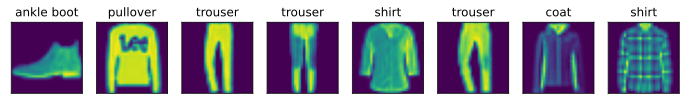

In [ ]:
@add_to_class(FashionMNIST)
def visualize(self, batch, nrows=1, ncols=8, labels=[]):
    X, y = batch
    if not labels:
        labels = self.text_labels(y)
    d2l.show_images(tf.squeeze(X), nrows, ncols, titles=labels)
batch = next(iter(data.val_dataloader()))
data.visualize(batch)

## 4.3. **The Base Classification Model**

#### 4.3.1. The Classifier Class

In [ ]:
class Classifier(Module):
    """The base class of classification models."""
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)

In [ ]:
@add_to_class(Module)
def configure_optimizers(self):
    return tf.keras.optimizers.SGD(self.lr)

#### 4.3.2 Accuracy

In [ ]:
@add_to_class(Classifier)
def accuracy(self, Y_hat, Y, averaged=True):
    """Compute the number of correct predictions."""
    Y_hat = tf.reshape(Y_hat, (-1, Y_hat.shape[-1]))
    preds = tf.cast(tf.argmax(Y_hat, axis=1), Y.dtype)
    compare = tf.cast(preds == tf.reshape(Y, -1), tf.float32)
    return tf.reduce_mean(compare) if averaged else compare

## 4.4. **Softmax Regression Implementation from Scratch**

#### 4.4.1. The Softmax

In [ ]:
X = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
tf.reduce_sum(X, 0, keepdims=True), tf.reduce_sum(X, 1, keepdims=True)

(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[5., 7., 9.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[ 6.],
        [15.]], dtype=float32)>)

In [ ]:
def softmax(X):
    X_exp = tf.exp(X)
    partition = tf.reduce_sum(X_exp, 1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

In [ ]:
X = tf.random.uniform((2, 5))
X_prob = softmax(X)
X_prob, tf.reduce_sum(X_prob, 1)

(<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[0.28115675, 0.16979009, 0.14119855, 0.21805024, 0.18980439],
        [0.24001223, 0.171884  , 0.17312631, 0.25983024, 0.15514717]],
       dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>)

#### 4.4.2. The Model

In [ ]:
class SoftmaxRegressionScratch(Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = tf.random.normal((num_inputs, num_outputs), 0, sigma)
        self.b = tf.zeros(num_outputs)
        self.W = tf.Variable(self.W)
        self.b = tf.Variable(self.b)

In [ ]:
@add_to_class(SoftmaxRegressionScratch)
def forward(self, X):
    X = tf.reshape(X, (-1, self.W.shape[0]))
    return softmax(tf.matmul(X, self.W) + self.b)

#### 4.4.3. The Cross-Entropy Loss

In [ ]:
y_hat = tf.constant([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = tf.constant([0, 2])
tf.boolean_mask(y_hat, tf.one_hot(y, depth=y_hat.shape[-1]))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.1, 0.5], dtype=float32)>

In [ ]:
def cross_entropy(y_hat, y):
    return -tf.reduce_mean(tf.math.log(tf.boolean_mask(
        y_hat, tf.one_hot(y, depth=y_hat.shape[-1]))))

cross_entropy(y_hat, y)

<tf.Tensor: shape=(), dtype=float32, numpy=1.4978662>

In [ ]:
@add_to_class(SoftmaxRegressionScratch)
def loss(self, y_hat, y):
    return cross_entropy(y_hat, y)

#### 4.4.4. Training

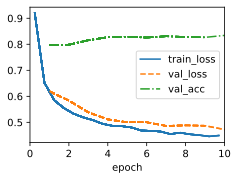

In [ ]:
data = FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
trainer = Trainer(max_epochs=10)
trainer.fit(model, data)

#### 4.4.5. Prediction

In [ ]:
X, y = next(iter(data.val_dataloader()))
preds = tf.argmax(model(X), axis=1)
preds.shape

TensorShape([256])

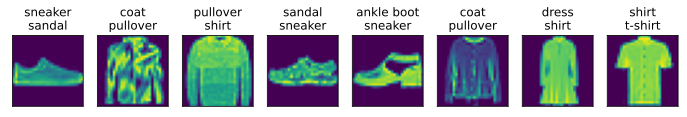

In [ ]:
wrong = tf.cast(preds, y.dtype) != y
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = [a+'\n'+b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))]
data.visualize([X, y], labels=labels)

#### Exercises

#### 4.5. Concise Implementation of Softmax Regression

#### 4.5.1. Defining the Model

In [ ]:
class SoftmaxRegression(Classifier):
    """The softmax regression model."""
    def __init__(self, num_outputs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential()
        self.net.add(tf.keras.layers.Flatten())
        self.net.add(tf.keras.layers.Dense(num_outputs))

    def forward(self, X):
        return self.net(X)

#### 4.5.2. Softmax Revisited

In [ ]:
@add_to_class(Classifier)
def loss(self, Y_hat, Y, averaged=True):
    Y_hat = tf.reshape(Y_hat, (-1, Y_hat.shape[-1]))
    Y = tf.reshape(Y, (-1,))
    fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    return fn(Y, Y_hat)

#### 4.5.3. Training

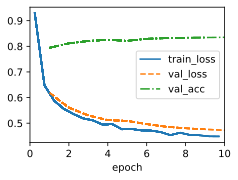

In [ ]:
data = FashionMNIST(batch_size=256)
model = SoftmaxRegression(num_outputs=10, lr=0.1)
trainer = Trainer(max_epochs=10)
trainer.fit(model, data)